<a href="https://colab.research.google.com/github/marsggbo/AutoMLDemos/tree/main/ch7/ResNet_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Dependencies and Import Modules

You shoud **restart/rerun** the runtime after running the following pip commands.

In [1]:
!pip install -q git+https://github.com/marsggbo/hyperbox.git

In [2]:
import argparse
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms

assert torch.cuda.is_available(), 'CUDA unavailable, invalid setup'

# Prepare CIFAR10 Datasets

In [3]:

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

batch_size = 128

DATAPATH = '/home/xihe/datasets/cifar10'
all_train_set = datasets.CIFAR10(root=DATAPATH, train=True, download=True, transform=train_transform)
length_set = len(all_train_set)
len_train_set = length_set // 2
len_val_set = length_set - len_train_set
train_set, val_set = torch.utils.data.random_split(all_train_set, [len_train_set, len_val_set])
test_set = datasets.CIFAR10(root=DATAPATH, train=False, download=True, transform=valid_transform)

print(f"length of train/val/test set: {len_train_set}/{len_val_set}/{len(test_set)}")

all_train_loader = torch.utils.data.DataLoader(all_train_set, batch_size=batch_size, shuffle=True, num_workers=2)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:16<00:00, 10266778.05it/s]


Extracting /home/xihe/datasets/cifar10\cifar-10-python.tar.gz to /home/xihe/datasets/cifar10
Files already downloaded and verified
length of train/val/test set: 25000/25000/10000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


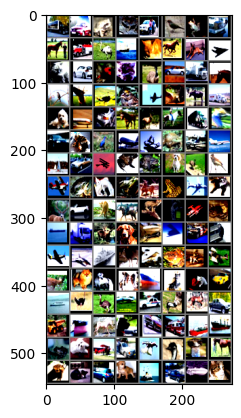

truck car frog frog car bird frog ship horse truck bird ship cat horse dog plane cat car bird cat bird car truck horse bird deer bird bird plane frog deer truck dog plane car horse deer horse truck bird car cat bird plane deer frog plane plane ship car plane frog frog dog bird bird plane frog cat frog deer frog plane cat deer car cat horse cat bird plane frog ship truck deer dog ship plane car cat plane plane ship deer bird frog deer plane deer dog horse dog ship cat cat car ship bird bird plane car bird horse car truck ship horse dog car truck ship ship frog dog plane car plane bird bird horse frog dog car dog ship car ship cat


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:1s}' for j in range(batch_size)))

# Train & Test Function

In [5]:
def train(train_loader, val_loader, network, mutator, criterion, w_opt, device, epoch):
    network.train()
    for batch_idx, ((train_x, train_y), (val_x, val_y)) in enumerate(zip(train_loader, val_loader)):
        train_x, train_y = train_x.to(device, non_blocking=True), train_y.to(device, non_blocking=True)
        val_x, val_y = val_x.to(device, non_blocking=True), val_y.to(device, non_blocking=True)

        # update weights
        w_opt.zero_grad(set_to_none=True)
        with torch.no_grad():
            mutator.reset()
        output = network(train_x)
        w_loss = criterion(output, train_y)
        w_loss.backward()
        w_opt.step()

        if (batch_idx + 1) % 100 == 0:
            print('Train Epoch: {} tLoss: {:.6f}'.format(epoch, w_loss.item()))
        

In [6]:

def validate(loader, network, criterion, device, num_batches=None, mutator=None, verbose=True):
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(loader):
            if num_batches is not None and batch_idx >= num_batches:
                break
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            output = network(x)
            loss = criterion(output, y)
            test_loss += loss.item()

            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(y.view_as(pred)).sum().item()
    test_loss /= len(loader.dataset)
    test_acc = 100. * correct / len(loader.dataset)

    if verbose:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(loader.dataset), test_acc))
    return {'loss': test_loss, 'acc': test_acc}

# Define a Supernet & Mutator

In [7]:
from hyperbox.networks.resnet import resnet18
from hyperbox.mutator import EvolutionMutator

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = resnet18(ratios=[0.5, 0.8, 1], num_classes=10).to(device)
mutator = EvolutionMutator(net)
mutator.reset()
print(mutator._cache)

{'layer4_outplanes1': tensor([False, False,  True]), 'layer1_inplanes': tensor([ True, False, False]), 'layer1_outplanes0': tensor([ True, False, False]), 'layer1_outplanes1': tensor([False, False,  True]), 'layer2_outplanes0': tensor([ True, False, False]), 'layer2_outplanes1': tensor([False,  True, False]), 'layer3_outplanes0': tensor([False,  True, False]), 'layer3_outplanes1': tensor([ True, False, False]), 'layer4_outplanes0': tensor([ True, False, False])}


# Pre-training Supernet

In [8]:
criterion = torch.nn.CrossEntropyLoss()
history = {}
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
network = net.to(device)
mutator = mutator.to(device)
w_opt = torch.optim.SGD(net.parameters(),  lr=0.01, momentum=0.9, weight_decay=5e-4)
train_epochs = 0
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(w_opt, T_max=train_epochs+20)
if os.path.exists('resnet18_supernet.pt'):
    network.load_state_dict(torch.load('resnet18_supernet.pt'))
    print("load pretrained supernet from resnet18_supernet.pt")
    train_epochs = 0
for epoch in range(train_epochs):
    train(train_loader, val_loader, network, mutator, criterion, w_opt, device, epoch)
    mask = mutator.export()
    mutator.sample_by_mask(mask)
    val_loss, val_acc = validate(test_loader, network, criterion, device, verbose=True)
    print(f"acc={val_acc} loss={val_loss}")
    torch.save(network.state_dict(), 'resnet18_supernet.pt')
    lr_scheduler.step()


# Search via Evolutionary Algorithm

In [12]:
topk = mutator.search(
    warmup_epochs=0,
    evolution_epochs=30,
    population_num=20,
    selection_alg='nsga2',
    selection_num=0.8,
    crossover_num=0.2,
    crossover_prob=0.3,
    mutation_num=0.2,
    mutation_prob=0.3,
    topk=10,
    eval_func=validate,
    eval_kwargs={'loader': val_loader, 'criterion': nn.CrossEntropyLoss(),
                'device': device, 'num_batches': None, 'verbose': False},
    eval_metrics_order={'acc': 'max'},
    size_limit=10, # MB, the maximum size of a model
    log_dir='evolution_logs_<10MB',
    to_save_checkpoint=True,
    to_plot_pareto=True,
    figname='evolution_pareto.pdf',
)
for i, subnet_info in enumerate(topk):
    acc = subnet_info['performance']['acc']
    loss = subnet_info['performance']['loss']
    size = subnet_info['size']
    flops = subnet_info['flops']
    print(f"{i}: acc={acc} loss={loss} size={size} flops={flops}")

torch.Size([2, 10])

## Finetune the Exported Subnet

In [9]:

def finetune(train_loader, network, criterion, w_opt, device, epoch):
    network.train()
    for batch_idx, (train_x, train_y) in enumerate(train_loader):
        train_x, train_y = train_x.to(device, non_blocking=True), train_y.to(device, non_blocking=True)

        # update weights
        w_opt.zero_grad(set_to_none=True)
        with torch.no_grad():
            mutator.reset()
        output = network(train_x)
        w_loss = criterion(output, train_y)
        w_loss.backward()
        w_opt.step()

In [10]:
def finetune_subnet(topk, index, net, all_train_loader, test_loader, criterion, device, size_original, finetune_epochs=50):
    subnet = net.build_subnet(mask=topk[0]['arch']).to(device)
    w_opt = torch.optim.Adam(subnet.parameters(),  lr=0.0005, weight_decay=5e-4)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(w_opt, T_max=finetune_epochs+20)
    best_val_acc = 0
    for epoch in range(finetune_epochs):
        finetune(all_train_loader, subnet, criterion, w_opt, device, epoch)
        results = validate(test_loader, subnet, criterion, device, verbose=False)
        val_loss, val_acc = results['loss'], results['acc']
        print(f"Epoch{epoch}: acc={val_acc} loss={val_loss}")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(network.state_dict(), f'resnet18_subnet{index}.pt')
        lr_scheduler.step()
    size_subnet = sum([p.numel() for p in subnet.parameters()])
    print(size_original, size_subnet, f"compressed by {(1-size_subnet/size_original)*100}%.")


In [17]:

size_original = sum([p.numel() for p in network.parameters()])
for i in range(len(topk)):
    print(f"finetune subnet {i}")
    finetune_subnet(topk, i, net, all_train_loader, test_loader, criterion, device, size_original)
